##### Copyright 2024 Google LLC.

In [100]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Model tuning with Python

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemini-api/docs/model-tuning/python"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
  </td>
    <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemini-api/docs/model-tuning/python.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemini-api/docs/model-tuning/python.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this notebook, you'll learn how to get started with the tuning service using the Python client library for the Gemini API. Here, you'll learn how to tune the text model behind the Gemini API's text generation service.

## Setup

### Install the client library

In [101]:
!pip install -q google-generativeai

### Import libraries

In [102]:
import google.generativeai as genai

In [103]:
from google.colab import userdata
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

You can check you existing tuned models with the `genai.list_tuned_model` method.

In [104]:
for i, m in zip(range(5), genai.list_tuned_models()):
  print(m.name)

tunedModels/generate-num-4913
tunedModels/generate-num-5302
tunedModels/generate-num-5849
tunedModels/polio-awareness-tuned-model-4751
tunedModels/polio-awareness-tuned-model-5428


## Create tuned model

To create a tuned model, you need to pass your dataset to the model in the `genai.create_tuned_model` method. You can do this be directly defining the input and output values in the call or importing from a file into a dataframe to pass to the method.

For this example, you will tune a model to generate the next number in the sequence. For example, if the input is `1`, the model should output `2`. If the input is `one hundred`, the output should be `one hundred one`.

In [105]:
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods and
    "flash" in m.name][0]
base_model

Model(name='models/gemini-1.5-flash-001-tuning',
      base_model_id='',
      version='001',
      display_name='Gemini 1.5 Flash 001 Tuning',
      description=('Version of Gemini 1.5 Flash that supports tuning, our fast and versatile '
                   'multimodal model for scaling across diverse tasks, released in May of 2024.'),
      input_token_limit=16384,
      output_token_limit=8192,
      supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
      temperature=1.0,
      max_temperature=2.0,
      top_p=0.95,
      top_k=64)

In [99]:
import random
import json

# Load the dataset from the JSON file
with open('polio_dataset.json', 'r') as f:
    training_data = json.load(f)

name = f'polio-awareness-tuned-model-{random.randint(0,10000)}'

operation = genai.create_tuned_model(
    source_model=base_model.name,
    training_data=training_data,
    id=name,
    epoch_count=100,
    batch_size=4,
    learning_rate=0.001,
)


Your tuned model is immediately added to the list of tuned models, but its status is set to "creating" while the model is tuned.

In [106]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model

TunedModel(name='tunedModels/polio-awareness-tuned-model-7991',
           source_model='models/gemini-1.5-flash-001-tuning',
           base_model='models/gemini-1.5-flash-001-tuning',
           display_name='',
           description='',
           temperature=1.0,
           top_p=0.95,
           top_k=64,
           state=<State.CREATING: 1>,
           create_time=datetime.datetime(2025, 5, 11, 12, 5, 22, 842062, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2025, 5, 11, 12, 5, 22, 842062, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=None,
                                  complete_time=None,
                                  snapshots=[],
                                  hyperparameters=Hyperparameters(epoch_count=100,
                                                                  batch_size=4,
                                                                  learning_rate=0.001)),
           reader_project_numbers=No

In [107]:
model.state

<State.CREATING: 1>

### Check tuning progress

Use `metadata` to check the state:

In [108]:
operation.metadata

total_steps: 1375
tuned_model: "tunedModels/polio-awareness-tuned-model-7991"

Wait for the training to finish using `operation.result()`, or `operation.wait_bar()`

In [ ]:
import time

for status in operation.wait_bar():
  time.sleep(30)

  0%|          | 0/1375 [00:00<?, ?it/s]

**uncomment if you want to cance**l You can cancel your tuning job any time using the `cancel()` method. Uncomment the line below and run the code cell to cancel your job before it finishes.

In [88]:
# operation.cancel()

Once the tuning is complete, you can view the loss curve from the tuning results. The [loss curve](https://ai.google.dev/gemini-api/docs/model-tuning#recommended_configurations) shows how much the model's predictions deviate from the ideal outputs.

<Axes: xlabel='epoch', ylabel='mean_loss'>

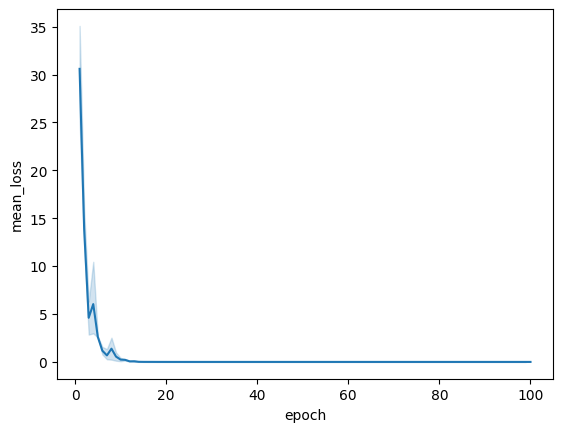

In [89]:
import pandas as pd
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')


## Evaluate your model

You can use the `genai.generate_content` method and specify the name of your model to test your model performance.

In [90]:
model = genai.GenerativeModel(model_name=f'tunedModels/{name}')

In [97]:
result = model.generate_content('what is polio?')
result.text

ValueError: ("Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 3. The candidate's safety_ratings are: [category: HARM_CATEGORY_SEXUALLY_EXPLICIT\nprobability: NEGLIGIBLE\n, category: HARM_CATEGORY_HATE_SPEECH\nprobability: NEGLIGIBLE\n, category: HARM_CATEGORY_HARASSMENT\nprobability: NEGLIGIBLE\n, category: HARM_CATEGORY_DANGEROUS_CONTENT\nprobability: MEDIUM\n].", [category: HARM_CATEGORY_SEXUALLY_EXPLICIT
probability: NEGLIGIBLE
, category: HARM_CATEGORY_HATE_SPEECH
probability: NEGLIGIBLE
, category: HARM_CATEGORY_HARASSMENT
probability: NEGLIGIBLE
, category: HARM_CATEGORY_DANGEROUS_CONTENT
probability: MEDIUM
])

In [94]:
result = model.generate_content('how totreat polio virus?')
result.text

'There is no specific treatment for the poliovirus once a person is infected.  The focus is on providing supportive care and managing the symptoms.  Vaccination is the best way to prevent polio.'

In [93]:
result = model.generate_content('ፖሊዮ እንዴት  እንደሚተላለፍ፣ እንደት መከላከል እንደሚቻል በዝርዝር ንገረኝ')
result.text

'ፖሊዮ በዋነኛነት በተበከለ ምግብ እና ውሃ ይተላለፋል።  እንዲሁም በቀጥታ ከሰው ወደ ሰው በኩፍኝ ጠብታዎች ሊተላለፍ ይችላል።  ፖሊዮን ለመከላከል በጣም ውጤታማው መንገድ ከፖሊዮ ክትባት መከተብ ነው።  እጅን በደንብ መታጠብ እና ንፅህናን መጠበቅ እንዲሁም ፖሊዮን ለመከላከል ይረዳል።'

In [95]:
result = model.generate_content('how polio transmit?')
result.text

'Polio is transmitted through person-to-person contact, usually through fecal-oral transmission. It can also be spread through contaminated food or water. Practicing good hygiene is important to prevent the spread of polio.'

In [20]:
result = model.generate_content('what is AFP?')
result.text

'IV'

In [21]:
result = model.generate_content('List steps to do when polio infection is reported?')
result.text

'八'

It really seems to have picked up the task despite the limited examples, but "next" is a simple concept, see the [tuning guide](https://ai.google.dev/gemini-api/docs/model-tuning) for more guidance on improving performance.

## Update the description

You can update the description of your tuned model any time using the `genai.update_tuned_model` method.

In [60]:
genai.update_tuned_model(f'tunedModels/{name}', {"description":"This is model is POlio(AFP) awearness creation chatbot assistant AI model ."});

In [61]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model.description

'This is model is POlio(AFP) awearness creation chatbot assistant AI model .'

## Delete the model

You can clean up your tuned model list by deleting models you no longer need. Use the `genai.delete_tuned_model` method to delete a model. If you canceled any tuning jobs, you may want to delete those as their performance may be unpredictable.

In [62]:
genai.delete_tuned_model(f'tunedModels/{name}')

The model no longer exists:

In [63]:
try:
  m = genai.get_tuned_model(f'tunedModels/{name}')
  print(m)
except Exception as e:
  print(f"{type(e)}: {e}")

<class 'google.api_core.exceptions.NotFound'>: 404 GET https://generativelanguage.googleapis.com/v1beta/tunedModels/polio-awareness-tuned-model-7120?%24alt=json%3Benum-encoding%3Dint: Tuned model tunedModels/polio-awareness-tuned-model-7120 does not exist.
